# Cat vs Dog Classifier

In [1]:
# !pip install bing-image-downloader

In [2]:
import os
import requests

import mlflow
import mlflow.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import MobileNet

from datetime import datetime
import matplotlib.pyplot as plt

from bing_image_downloader import downloader
from pathlib import Path
import imghdr

## Download images

In [3]:
image_path = "./data/cat_dogs/"

In [4]:
# def download_images(query, limit, output_dir):
    
#     downloader.download(query,
#                         limit=limit,
#                         output_dir=output_dir,
#                         adult_filter_off=True,
#                         force_replace=False,
#                         timeout=60)

# download_images("cat", 100, image_path)
# download_images("dog", 100, image_path)

### Check the downloaded images

In [5]:
for category in ["cat","dog"]:
    data_dir = os.path.join(image_path, category)
    image_extensions = [".png", ".jpg"]  # add there all your images file extensions

    img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
    for filepath in Path(data_dir).rglob("*"):
        if filepath.suffix.lower() in image_extensions:
            img_type = imghdr.what(filepath)
            if img_type is None:
                print(f"{filepath} is not an image")
            elif img_type not in img_type_accepted_by_tf:
                print(f"{filepath} is a {img_type}, not accepted by TensorFlow")

**Delete any invalid images**

## Model Training

### Define parameters

In [40]:
# Define hyperparameters and input data
learning_rate = 0.01
num_epochs = 50
batch_size = 32
input_shape = (224, 224, 3)

In [26]:
# Define names for tensorboard logging and mlflow
experiment_name = "cat-dog-classifier-mobilenet"
run_name = datetime.now().strftime("%Y%m%d_%H%M%S")

### Read Data

In [27]:
# Load the dataset
train_dataset = keras.preprocessing.image_dataset_from_directory(
    image_path,
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=input_shape[:2],
    batch_size=batch_size,
)

Found 195 files belonging to 2 classes.
Using 156 files for training.


In [28]:
val_dataset = keras.preprocessing.image_dataset_from_directory(
    image_path,
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=input_shape[:2],
    batch_size=batch_size,
)

Found 195 files belonging to 2 classes.
Using 39 files for validation.


Look at some sample images from the datasets

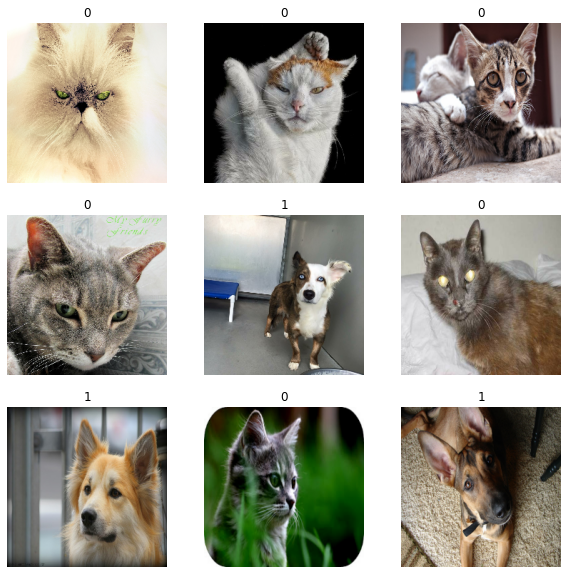

In [29]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

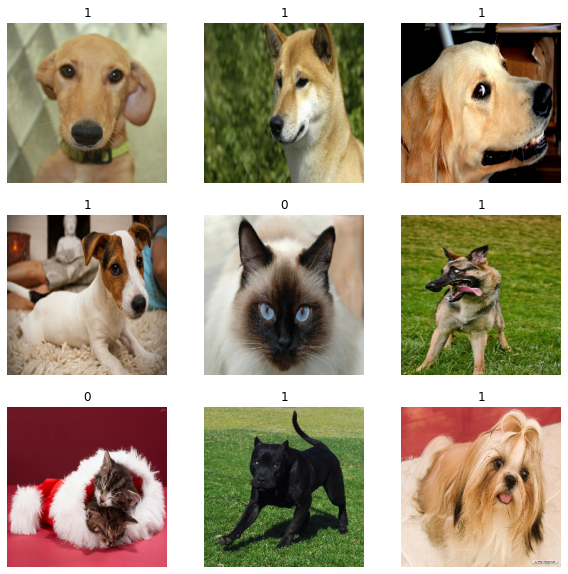

In [30]:
plt.figure(figsize=(10, 10))
for images, labels in val_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

### Data Augmentation

In [31]:
data_augmentation = keras.Sequential(
    [
        keras.layers.RandomFlip("horizontal"),
        keras.layers.RandomRotation(0.1),
    ]
)

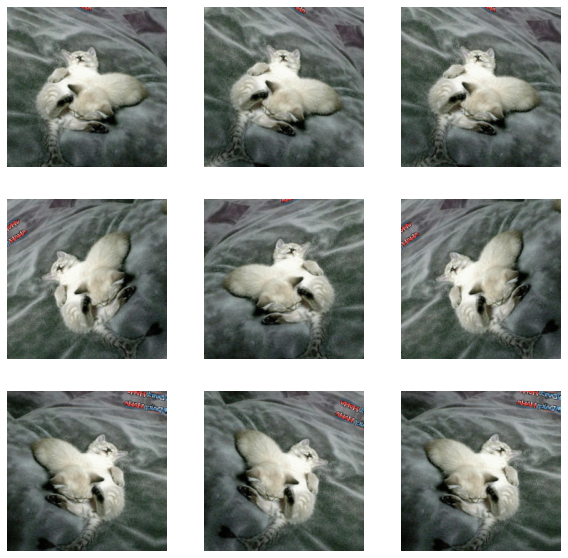

In [32]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images, training=True)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [33]:
augmented_train_dataset = train_dataset.map(
    lambda x, y: (data_augmentation(x, training=True), y))

### Define Model and Train

In [42]:
# Define the base model and add a classifier on top
base_model = MobileNet(input_shape=input_shape, include_top=False, weights="imagenet")
base_model.trainable = False
model = keras.Sequential([
    base_model,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(2, activation="softmax")
])

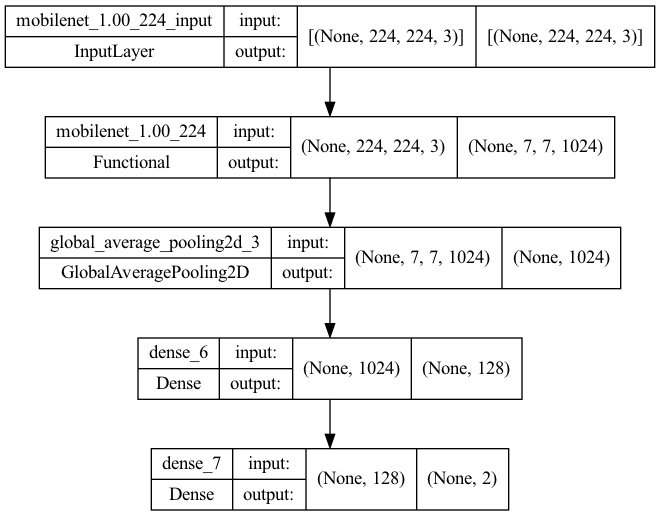

In [43]:
keras.utils.plot_model(model, show_shapes=True)

In [44]:
 # Compile the model with a loss function and optimizer
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    metrics=["accuracy"],
)

In [45]:
logdir = os.path.join("logs", experiment_name, run_name)
tb_callback = keras.callbacks.TensorBoard(log_dir=logdir, write_graph=True, histogram_freq=1)

In [46]:
# Train the model and log metrics and the model itself to MLflow
history = model.fit(
    augmented_train_dataset,
    epochs=num_epochs,
    validation_data=val_dataset,
    verbose=2,
    callbacks=[tb_callback]
)

Epoch 1/50
5/5 - 9s - loss: 6.6338 - accuracy: 0.5256 - val_loss: 4.3493 - val_accuracy: 0.5128 - 9s/epoch - 2s/step
Epoch 2/50
5/5 - 8s - loss: 3.2417 - accuracy: 0.4808 - val_loss: 1.4541 - val_accuracy: 0.4872 - 8s/epoch - 2s/step
Epoch 3/50
5/5 - 8s - loss: 1.3098 - accuracy: 0.5321 - val_loss: 0.5324 - val_accuracy: 0.7692 - 8s/epoch - 2s/step
Epoch 4/50
5/5 - 8s - loss: 1.0201 - accuracy: 0.5641 - val_loss: 0.4980 - val_accuracy: 0.7949 - 8s/epoch - 2s/step
Epoch 5/50
5/5 - 8s - loss: 0.7915 - accuracy: 0.6282 - val_loss: 0.4950 - val_accuracy: 0.8462 - 8s/epoch - 2s/step
Epoch 6/50
5/5 - 8s - loss: 0.5741 - accuracy: 0.7051 - val_loss: 0.4610 - val_accuracy: 0.7949 - 8s/epoch - 2s/step
Epoch 7/50
5/5 - 8s - loss: 0.4688 - accuracy: 0.7436 - val_loss: 0.4707 - val_accuracy: 0.7949 - 8s/epoch - 2s/step
Epoch 8/50
5/5 - 8s - loss: 0.4507 - accuracy: 0.7821 - val_loss: 0.4147 - val_accuracy: 0.7949 - 8s/epoch - 2s/step
Epoch 9/50
5/5 - 8s - loss: 0.4278 - accuracy: 0.7692 - val_loss

KeyboardInterrupt: 

### Logging and Visualization

In [ ]:
# Set the experiment name and create an MLflow run
mlflow.set_experiment(experiment_name)
with mlflow.start_run(run_name = run_name) as mlflow_run:
    
    mlflow.set_experiment_tag("base_model", "MobileNet")
    mlflow.set_tag("optimizer", "keras.optimizers.Adam")
    mlflow.set_tag("loss", "sparse_categorical_crossentropy")

    mlflow.keras.log_model(model, "model")

    mlflow.log_param("learning_rate", learning_rate)
    mlflow.log_param("num_epochs", num_epochs)
    mlflow.log_param("batch_size", batch_size)
    mlflow.log_param("input_shape", input_shape)

    mlflow.log_metric("train_loss", history.history["loss"][-1])
    mlflow.log_metric("train_acc", history.history["accuracy"][-1])
    mlflow.log_metric("val_loss", history.history["val_loss"][-1])
    mlflow.log_metric("val_acc", history.history["val_accuracy"][-1])

    mlflow.log_artifact("model.png", "model_plot")

    mlflow_run_id = mlflow_run.info.run_id
    print("MLFlow Run ID: ", mlflow_run_id)

In [47]:
%load_ext tensorboard
%tensorboard --logdir logs/cat-dog-classifier-mobilenet

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


### Predictions

In [48]:
img = keras.preprocessing.image.load_img(
    os.path.join(image_path, "cat/Image_17.jpg"), target_size=input_shape
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

This image is 86.84% cat and 13.16% dog.


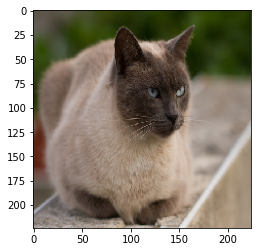

In [49]:
predictions = model.predict(img_array)
print("This image is {:.2f}% cat and {:.2f}% dog.".format(100 * float(predictions[0][0]),
                                                          100 * float(predictions[0][1])))

plt.imshow(img_array[0].numpy().astype("uint8"))

**Using MLFlow to predict**

In [50]:
# Logged model in MLFlow
logged_model_path = f"runs:/{mlflow_run_id}/model"

# Load model as a Keras model
loaded_model = mlflow.keras.load_model(logged_model_path)

This image is 99.60% cat and 0.40% dog.


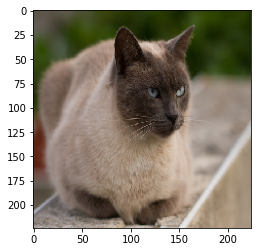

In [52]:
predictions = loaded_model.predict(img_array)
print("This image is {:.2f}% cat and {:.2f}% dog.".format(100 * float(predictions[0][0]),
                                                          100 * float(predictions[0][1])))

plt.imshow(img_array[0].numpy().astype("uint8"))

## Model Registration

In [53]:
model_name = "cat_dog_classifier"
model_version = 1

In [54]:
print("MLFlow Run ID: ", mlflow_run_id)

MLFlow Run ID:  17d968196b214e13aa682abd46b82107


In [55]:
with mlflow.start_run(run_id=mlflow_run_id) as run:
    result = mlflow.register_model(
        logged_model_path,
        model_name
    )

Successfully registered model 'cat_dog_classifier'.
2023/04/16 17:43:46 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: cat_dog_classifier, version 1
Created version '1' of model 'cat_dog_classifier'.


This image is 99.60% cat and 0.40% dog.


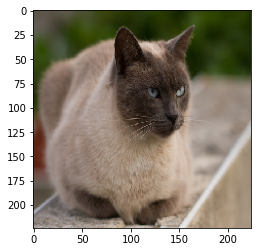

In [57]:
# Load model as a Keras model
loaded_model = mlflow.keras.load_model(
    model_uri=f"models:/{model_name}/{model_version}"
)

predictions = loaded_model.predict(img_array)
print("This image is {:.2f}% cat and {:.2f}% dog.".format(100 * float(predictions[0][0]),
                                                          100 * float(predictions[0][1])))

plt.imshow(img_array[0].numpy().astype("uint8"))

## Transition model to production

In [58]:
client = mlflow.tracking.MlflowClient()
client.transition_model_version_stage(
    name=model_name,
    version=model_version,
    stage="Production"
)

<ModelVersion: creation_timestamp=1681647226611, current_stage='Production', description=None, last_updated_timestamp=1681647415337, name='cat_dog_classifier', run_id='17d968196b214e13aa682abd46b82107', run_link=None, source='file:///Users/harshkumar/Documents/Harsh/My_Git/learning/machine_learning/keras/mlruns/594654635064480410/17d968196b214e13aa682abd46b82107/artifacts/model', status='READY', status_message=None, tags={}, user_id=None, version=1>

This image is 99.60% cat and 0.40% dog.


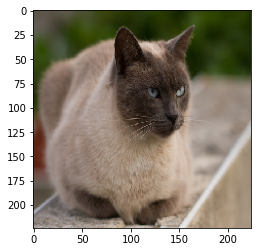

In [59]:
# Load model as a Keras model
loaded_model = mlflow.keras.load_model(
    model_uri=f"models:/{model_name}/production"
)

predictions = loaded_model.predict(img_array)
print("This image is {:.2f}% cat and {:.2f}% dog.".format(100 * float(predictions[0][0]),
                                                          100 * float(predictions[0][1])))

plt.imshow(img_array[0].numpy().astype("uint8"))

## Create endpoint for model serving

- Set environment variable for MLFlow URI  
`export MLFLOW_TRACKING_URI=http://localhost:5000`


- Start MLFlow Server for the model  
`mlflow models serve --model-uri models:/cat_dog_classifier/production -p 7777 --no-conda`

In [61]:
endpoint = "http://localhost:7777/invocations"

This image is 99.60% cat and 0.40% dog.


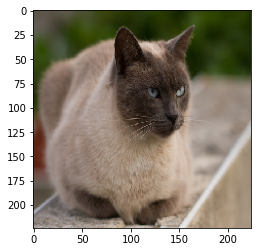

In [62]:
image_request = {
        "instances":img_array.numpy().tolist()
}

response = requests.post(endpoint, json=image_request)

predictions = eval(response.text)["predictions"]
print("This image is {:.2f}% cat and {:.2f}% dog.".format(100 * float(predictions[0][0]),
                                                          100 * float(predictions[0][1])))

plt.imshow(img_array[0].numpy().astype("uint8"))